# Assignment 1
### 001048178 Haoyuan Qin

HaagenDazs IceCream has different flavours like Vanilla, Chocolate, Coffee and etc. Normally we will find 5 to 6 different flavours in stores. So we will curious about which one will be the best. On HaagenDazs' website, top rated flavours are all 4.8. So in this assignment, I will try to use different strategies to find the best one in this 5 top rated flavours.

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

stationary=True
class Bandit():
  def __init__(self, arm_count):
    """
    Multi-armed bandit with rewards 1 or 0.
    
    At initialization, multiple arms are created. The probability of each arm
    returning reward 1 if pulled is sampled from Bernouilli(p), where p randomly
    chosen from Uniform(0,1) at initialization
    """
    self.arm_count = arm_count
    self.generate_thetas()
    self.timestep = 0
    global stationary
    self.stationary=stationary
    
  def generate_thetas(self):
    self.thetas = np.random.uniform(0,1,self.arm_count)
  
  def get_reward_regret(self, arm):
    """ Returns random reward for arm action. Assumes actions are 0-indexed
    Args:
      arm is an int
    """
    self.timestep += 1
    if (self.stationary==False) and (self.timestep%100 == 0) :
      self.generate_thetas()
    # Simulate bernouilli sampling
    sim = np.random.uniform(0,1,self.arm_count)
    rewards = (sim<self.thetas).astype(int)
    reward = rewards[arm]
    regret = self.thetas.max() - self.thetas[arm]
    
    return reward, regret



In [63]:
class BetaAlgo():
  """
  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the Bandit arms with a Beta, 
  assuming the true probability of success of an arm is Bernouilli distributed.
  """
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.alpha = np.ones(self.arm_count)
    self.beta = np.ones(self.arm_count)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.alpha[arm] += reward
    self.beta[arm] += 1 - reward

class BernGreedy(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)
  
  @staticmethod
  def name():
    return 'beta-greedy'
   
  def get_action(self):
    """ Bernouilli parameters are the expected values of the beta"""
    theta = self.alpha / (self.alpha + self.beta)
    return theta.argmax()
  
class BernThompson(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)

  @staticmethod
  def name():
    return 'thompson'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the beta"""
    theta = np.random.beta(self.alpha, self.beta)
    return theta.argmax()



In [64]:
epsilon = 0.1
class EpsilonGreedy():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global epsilon
    self.epsilon = epsilon
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) # action count
  
  @staticmethod
  def name():
    return 'epsilon-greedy'
  
  def get_action(self):
    if np.random.uniform(0,1) > self.epsilon:
      action = self.Q.argmax()
    else:
      action = np.random.randint(0, self.arm_count)
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule
 
  

In [65]:
ucb_c = 2
class UCB():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global ucb_c
    self.ucb_c = ucb_c
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) + 0.0001 # action count
    self.timestep = 1
  
  @staticmethod
  def name():
    return 'ucb'
  
  def get_action(self):
    ln_timestep = np.log(np.full(self.arm_count, self.timestep))
    confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
    action = np.argmax(self.Q + confidence)
    self.timestep += 1
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

In [66]:
class Random():
    def __init__(self, bandit):
        self.bandit = bandit
        self.arm_count = bandit.arm_count
        
    @staticmethod
    def name():
        return 'random'
    
    def get_action(self):
        action = np.random.randint(0, self.arm_count)
        return action
    
    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        return reward, regret

In [67]:
def plot_data(y):
  """ y is a 1D vector """
  x = np.arange(y.size)
  _ = plt.plot(x, y, 'o')
  
def multi_plot_data(data, names):
  """ data, names are lists of vectors """
  x = np.arange(data[0].size)
  for i, y in enumerate(data):
    plt.plot(x, y, 'o', markersize=2, label=names[i])
  plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
  plt.show()
  
def simulate(simulations, timesteps, arm_count, Algorithm):
  """ Simulates the algorithm over 'simulations' epochs """
  sum_regrets = np.zeros(timesteps)
  for e in range(simulations):
    bandit = Bandit(arm_count)
    algo = Algorithm(bandit)
    regrets = np.zeros(timesteps)
    for i in range(timesteps):
      action = algo.get_action()
      reward, regret = algo.get_reward_regret(action)
      regrets[i] = regret
    sum_regrets += regrets  
  mean_regrets = sum_regrets / simulations
  return mean_regrets

def experiment(arm_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
  algos = [EpsilonGreedy, UCB, BernThompson, Random]
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

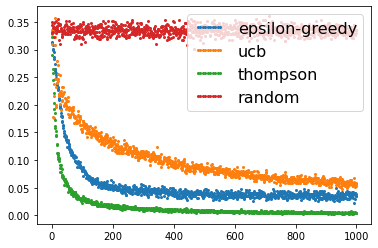

In [68]:
arm_count = 5
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

## Question 1

### Which hyperparameters are important for Thompson Sampling, e-greedy, UBC, and random sampling? Show that they are important (15 Points) 

#### Answer: 
Thompson Sampling --- no hyperparameters,

e-greedy --- e, e determine exploitation and exploration rate, 

UBC --- C, 

Random --- no hyperparameters


## Question 2

### How does the action space affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why. (15 Points) 

### Answer: 
The e -greedy agent barely budges in its learning pattern when compared to the baseline. The Thompson agent very slowly. UCB is drastically unstable and diverges
The greedy algorithm need only sample a few values and has a high probability of its most favourable action's estimated reward probability being close to the true optimal reward probability, ensuring it a low regret, even if it never chooses the optimal action. Thompson and UCB, on the other hand, with their emphasis on exploration, give a high premium to exploring actions not yet seen. It will do nothing to Random sampling.


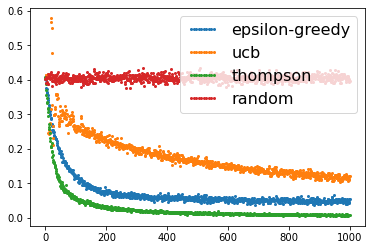

In [15]:
arm_count = 10
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

## Question 3

### How does stationary affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why. (15 Points) 

Answer: It resamples the action Bernouilli parameters. This places special emphasis on exploration. An algorithm that converges to an action and does not emphasize exploration will perform quite poorly as the true reward distribution changes over time. It will do nothing to Random sampling.


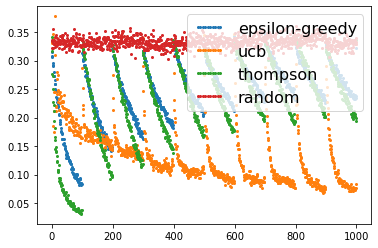

In [16]:
arm_count = 5
epsilon = 0.1
ucb_c = 2
stationary=False
experiment(arm_count)

## Question 4

### When do Thompson Sampling, e-greedy, UBC, and random sampling stop exploring? Explain why. Explain the exploration-exploitation tradeoff (15 Points) 

Answer: e-greedy is depended on the e value. The exploration-exploitation trade-off is between choosing what you know and getting something close to what you expect ('exploitation') and choosing something you aren't sure about and possibly learning more ('exploration'). Random sampling do not have exploration-exploitation tradeoff


## Question 5

### How long do Thompson Sampling, e-greedy, UBC, and random sampling remember the past actions? Explain your answer. (10 Points) 

Thompson Sampling remembers past actions when runs in beta distribution(𝛼 and 𝛽) to select action.

e-greedy remembers past action when needs its data to explored.

UCB remembers past action when needs its data to explored.

Random Sampling does not remember the past actions.

## Question 6

### Thompson Sampling with non-Beta distribution (5 Points)


In [94]:
class normalThompson(BetaAlgo):
    def __init__(self, bandit):
        self.bandit = bandit
        self.arm = bandit.arm_count
        self.mu = np.ones(self.arm)
        self.sigma = np.ones(self.arm)
        self.good = np.ones(self.arm)
        self.bad = np.ones(self.arm)
  
    
    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        self._update_params(arm, reward)
        return reward, regret
  
  
    def _update_params(self, arm, reward):
        self.good[arm] += reward
        self.bad[arm] += 1 - reward
        self.mu = self.good / (self.good + self.bad)
        self.sigma = (self.good * self.bad)/((self.good + self.bad)**2 * (self.good + self.bad +1))

    @staticmethod
    def name():
        return 'normalthompson'
  
    def get_action(self):
        theta = np.random.normal(self.mu, self.sigma)
        return theta.argmax()

In [95]:
def experimentnonbeta(arm_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
  algos = [EpsilonGreedy, UCB, BernThompson, Random, normalThompson]
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

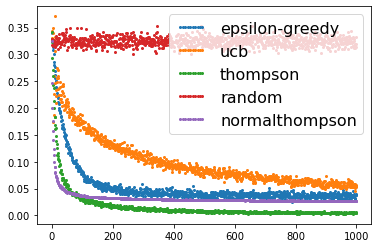

In [96]:
arm_count = 5
epsilon = 0.1
ucb_c = 2
stationary=True
experimentnonbeta(arm_count)

## Question 7

### What code is yours and what have you adapted? (10 Points)

Answer: I adapted following source of code and I write code for normal Thompson Sampling and changed some parameters in some functions.

### References

https://blog.csdn.net/u010510549/article/details/86476151

https://blog.csdn.net/lafengxiaoyu/article/details/102634543

https://www.zhaoyabo.com/?p=554

https://github.com/andrecianflone/thompson/blob/master/thompson.ipynb

## Licensing

Copyright (c) 2022, Haoyuan Qin All rights reserved.

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.